In [1]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import matplotlib.colors 
import tqdm
import scipy.signal
import statsmodels.tsa.stattools

In [28]:
#in this version we compute var on the filtered time series (to catch more dynamic in f) and ar on the "unfiltered" to have memory effect preserved

#define time interval, T should be integer
T = 1000

def mu(t):
    return 2/T * t - 1

epsilon = 0.01

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))/epsilon

In [29]:
def get_equilibria_paths():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[2.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[-2.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,ts[i]),(0.0,50),[0.0], method="BDF")
        unstable[i] = sol.y[0,-1]
     
    unstable[np.abs(unstable)>1] = np.nan

    return ts,upper,lower,unstable

In [30]:
ts, upper, lower, unstable = get_equilibria_paths()

100%|██████████| 1001/1001 [00:37<00:00, 26.87it/s]


In [31]:
#numerical simulation of SDEs:

steps_per_unit_time = 1000                                             
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
xs_white[0] = 2.103803356099623

sigma = 0.05
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]



#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                       #upper[0]
kappa = 0.1                                                                        #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
xs_red_filtered = xs_red[::steps_per_unit_time]


100%|██████████| 1000000/1000000 [00:01<00:00, 530831.83it/s]


In [102]:
#inspect noise var of wiener noise and red noise
T = 1000
steps_per_unit_time = 10
dt = 1/steps_per_unit_time
sigma = 0.1
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time)

wiener = np.zeros(T*steps_per_unit_time + 1)
for i in tqdm.trange(T*steps_per_unit_time):
    wiener[i+1] = wiener[i] + sigma*white_noise[i]

100%|██████████| 10000/10000 [00:00<00:00, 783323.19it/s]


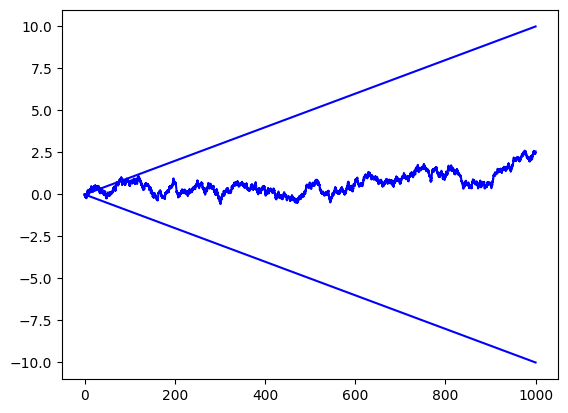

In [103]:
x = np.linspace(0,T,T*steps_per_unit_time + 1)
plt.plot(x,wiener,color = "blue")
plt.plot(x,sigma**2*x, color = "blue")
plt.plot(x,-sigma**2*x, color = "blue")
# plt.plot(np.linspace(0,T,T*steps_per_unit_time),eta)

100%|██████████| 1000000/1000000 [00:04<00:00, 209186.73it/s]


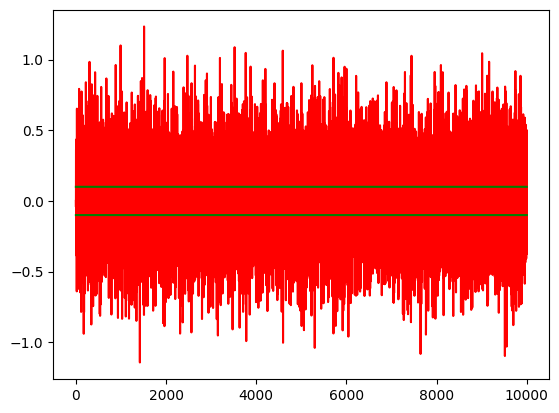

In [104]:
#

T = 10000
steps_per_unit_time = 100
dt = 1/steps_per_unit_time

theta = 5

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time + 1)
    for i in tqdm.trange(T*steps_per_unit_time):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(theta)

x = np.arange(0,T+1)
plt.plot(x,eta[::steps_per_unit_time],color = "red")
plt.plot(x,1/(2*theta)*np.ones(T+1),color = "green")
plt.plot(x,-1/(2*theta)*np.ones(T+1),color = "green")

# x = np.linspace(0,T,T*steps_per_unit_time)
# plt.plot(x,eta, color = "red")
# plt.plot(x, 1/(2*theta)*np.ones(T*steps_per_unit_time), color = "green")
# plt.plot(x,-1/(2*theta)*np.ones(T*steps_per_unit_time), color = "green")

In [32]:
window_length = 50 

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    n_windows = int(T/window_length) 
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var
        
        

def get_ar(x):
    #x should have size T*steps_per_unit_time + 1
    ar = np.full(T+1,np.nan)
    for i in tqdm.tgrange(T):
        ar[i+1] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2))[1]
    return ar

100%|██████████| 20/20 [00:00<00:00, 6565.91it/s]
c:\Users\mdichgan\AppData\Local\miniconda3\envs\bachelor_thesis\lib\site-packages\tqdm\gui.py:181: TqdmExperimentalWarning: GUI is experimental/alpha
  return tqdm_gui(range(*args), **kwargs)


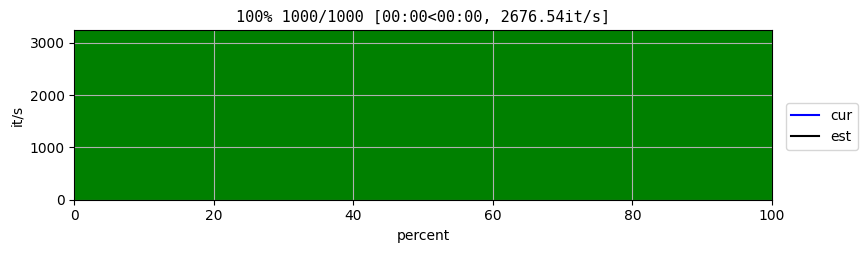

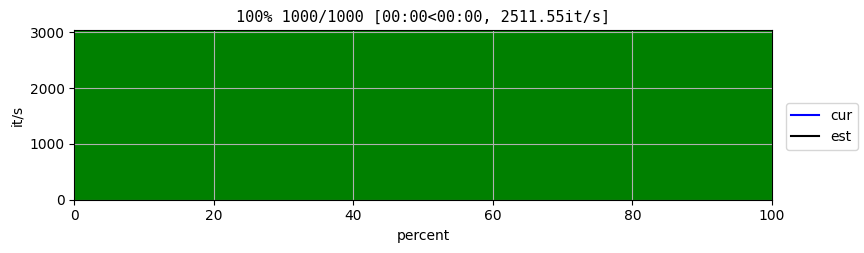

In [33]:
variance_series_white = get_var(xs_white_filtered)
variance_series_red = get_var(xs_red_filtered)
ac_series_white = get_ar(xs_white)
ac_series_red = get_ar(xs_red)


log_ac_white = np.log(ac_series_white)                           
log_ac_red = np.log(ac_series_red)

Text(0.5, 0, 'mu')

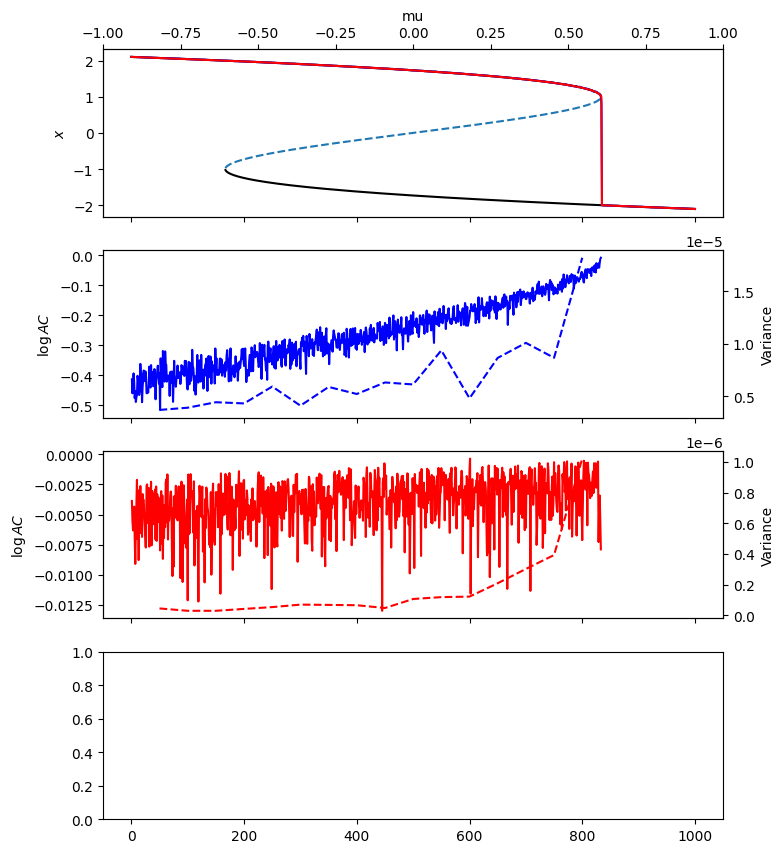

In [34]:

tipp_upper = np.argmin(upper>1)
tipp_lower = np.argmin(lower>-1)


tip_white = np.argmin(xs_white_filtered>1.0)
tip_red = np.argmin(xs_red_filtered>1.0)  


fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts[:tipp_upper],upper[:tipp_upper],color = "black")
axs[0].plot(ts[tipp_lower:],lower[tipp_lower:],color = "black")
axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
axs[0].plot(ts,xs_white_filtered,color="blue")
axs[0].plot(ts,xs_red_filtered,color="red")


axs[1].plot(ts[:tip_white],log_ac_white[:tip_white],color="blue")                               
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length:tip_white:window_length],variance_series_white[:int(tip_white/window_length)],color="blue",linestyle="--")


axs[2].plot(ts[:tip_red],log_ac_red[:tip_red],color="red")
ax2_var = axs[2].twinx()
ax2_var.plot(ts[window_length:tip_red:window_length],variance_series_red[:int(tip_red/window_length)],color="red",linestyle="--")


axs[0].set_ylabel(r"$x$")
axs[1].set_ylabel(r"$\log AC$")
axs[2].set_ylabel(r"$\log AC$")
ax1_var.set_ylabel(r"Variance")
ax2_var.set_ylabel(r"Variance")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel("mu")


In [50]:
start_t = 700
stop_t = 800

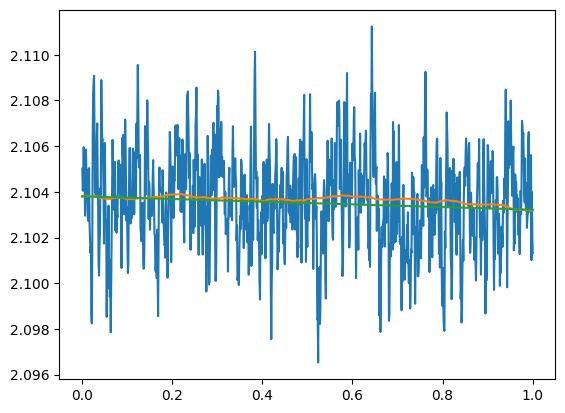

In [38]:
#all steps from unit time i to unit time j

n_steps = (stop_t - start_t)*steps_per_unit_time

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_red[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(ts[start_t:stop_t + 1],upper[start_t:stop_t + 1])


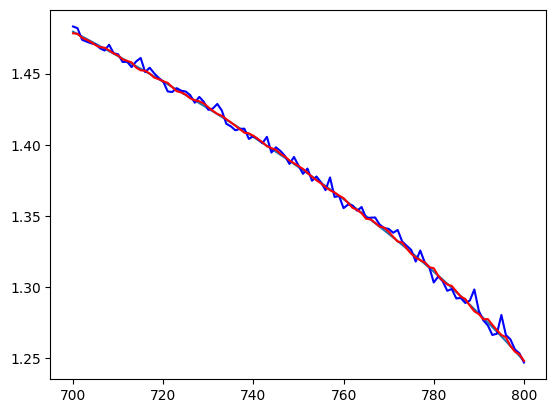

In [51]:
#filtered time series

plt.plot(np.arange(start_t,stop_t + 1),upper[start_t:stop_t + 1])
plt.plot(np.arange(start_t,stop_t + 1),xs_white_filtered[start_t:stop_t + 1],color = "blue")
plt.plot(np.arange(start_t,stop_t + 1),xs_red_filtered[start_t:stop_t + 1], color = "red")

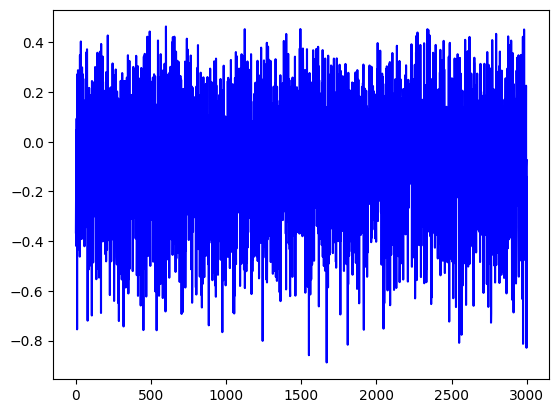

In [26]:
plt.plot(np.arange(start_t,stop_t + 1), ac_series_white[start_t:stop_t + 1],color = "blue")